In [1]:
from mvlearn.datasets.GaussianMixture import GaussianMixture
from mvlearn.cluster.mv_k_means import MultiviewKMeans

In [8]:
import numpy as np
from scipy.stats import ortho_group
import collections
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
import numpy as np
from scipy.stats import ortho_group
import collections
import matplotlib.pyplot as plt

def add_noise(X, n_noise):
    noise = np.random.randn(X.shape[0], n_noise)
    return np.hstack((X, noise))

def linear2view(X, n_noise, seed=2):
    np.random.seed(seed)
    if X.shape[1] > 1:
        X = X * np.random.normal(2, 1)
    else:
        X = X @ ortho_group.rvs(X.shape[1])
    return X

def poly2view(X, n_noise, seed=2):
    X = np.asarray([np.power(x, 3) for x in X])
    return X

def polyinv2view(X, n_noise, seed=2):
    X = np.asarray([np.cbrt(x) for x in X])
    return X

def sin2view(X, n_noise, seed=2):
    X = np.asarray([np.sin(x) for x in X])
    return X


class GaussianMixture:
    def __init__(self, n, seed, mu, sigma, class_sizes = None):
        self.mu = mu
        self.sigma = sigma
        self.views = len(mu)
        self.class_sizes = class_sizes

        np.random.seed(seed)
        if class_sizes is None:
            self.latent = np.random.multivariate_normal(mu, sigma, size=n)
            self.y = None
        else:
            self.latent = np.concatenate(
                [
                    np.random.multivariate_normal(
                        self.mu[i], self.sigma[i], size=class_sizes[i]
                    ) for i in range(len(class_sizes))
                ]
            )
            self.y = np.concatenate([i*np.zeros(class_sizes[i]) 
                                     for i in range(len(class_sizes))
                                    ])

    def sample_views(self, n_noise=1, transform='linear', seeds=[1,2]):
        """
        Parameters
        ----------
        sn_noise : int, default = 1
            number of noise dimensions to add to transformed latent
        transform : string, default = 'linear'
            Type of transformation to form views
            - value can be 'linear', 'sin', 'polyinv', 'poly', or custom function
        seeds : 1D array-like
            list of seeds to use in generating views, for reproducibility
        """

        if isinstance(transform, collections.Callable):
            X = np.asarray([transform(x) for x in self.latent])
        elif transform == "linear":
            X = linear2view(self.latent, n_noise=n_noise, seed=seeds[1])
        elif transform == "poly":
            X = poly2view(self.latent, n_noise=n_noise, seed=seeds[1])
        elif transform == "polyinv":
            X = polyinv2view(self.latent, n_noise=n_noise, seed=seeds[1])
        elif transform == "sin":
            X = sin2view(self.latent, n_noise=n_noise, seed=seeds[1])

        X = add_noise(X, n_noise=n_noise)
        self.Xs = [add_noise(self.latent, n_noise=n_noise), X]

    def plot_2views(self, Xs=None, figsize=(10, 10), title=""):
        if Xs is None:
            Xs = self.Xs
        n = Xs[0].shape[1]
        fig, axes = plt.subplots(n, n, figsize=figsize)
        for i, ax in enumerate(axes.flatten()):
            dim2 = int(i / n)
            dim1 = i % n
            ax.scatter(Xs[0][:, dim1], Xs[1][:, dim2])
            if dim2 == 2:
                ax.set_xlabel(f"View 1 Dim {dim1+1}")
            if dim1 == 0:
                ax.set_ylabel(f"View 2 Dim {dim2+1}")

        plt.suptitle(title)
        return (fig, axes)


In [14]:
## Training
n = 100
mu = [[0,1], [0,-1]]
sigma = [np.eye(2), np.eye(2)]
seed = 1
class_sizes = [50,50]
GM = GaussianMixture(n,seed,mu,sigma,class_sizes=class_sizes)

GM.sample_views(transform='poly', n_noise=3)

train_Xs = GM.Xs
train_y = GM.y

/home/rflperry/miniconda3/envs/mvdev/lib/python3.7/site-packages/ipykernel_launcher.py:67: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working


In [21]:
## Training
n = 100
mu = [[0,1], [0,-1]]
sigma = [np.eye(2), np.eye(2)]
seed = 2
class_sizes = [50,50]
GM = GaussianMixture(n,seed,mu,sigma,class_sizes=class_sizes)

GM.sample_views(transform='poly', n_noise=3)

test_Xs = GM.Xs
test_y = GM.y

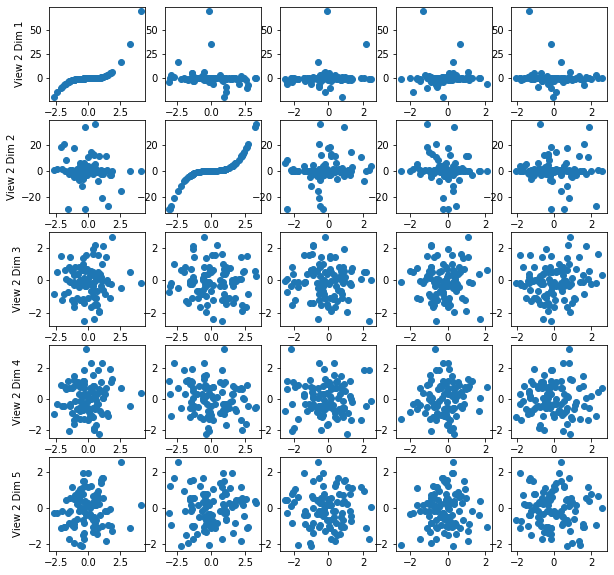

In [22]:
fig, axes = GM.plot_2views()
plt.show()

In [23]:
clf = MultiviewKMeans(n_clusters=2)

In [24]:
clf.fit(train_Xs)

MultiviewKMeans(max_iter=None, n_clusters=2, n_init=5, patience=5,
                random_state=None)

In [25]:
yhat_train = clf.predict(train_Xs)
yhat_test = clf.predict(test_Xs)

In [26]:
print(f'Train Error: {sum(np.abs(yhat_train - train_y)) / len(train_y)}')
print(f'Test Error: {sum(np.abs(yhat_test - test_y)) / len(test_y)}')

Train Error: 0.98
Test Error: 0.98
